## Nesterov Accelerated Gradient

In this section, we look at how Nesterov's Accelerated Gradient (NAG) performs as our optimizer. This is partly inspired by [Sutskever et al. 2013](http://proceedings.mlr.press/v28/sutskever13.pdf) and [this stackoverflow](https://stackoverflow.com/questions/50774683/how-is-nesterovs-accelerated-gradient-descent-implemented-in-tensorflow) post on [TensorFlow's implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) of NAG.

### Theory vs Implementation

It is worth noting that the original NAG uses momentum to update weights. So for a weight $\theta_t$, a loss function that we are minimizing $f(theta_t)$ with gradient $\nabla f(\theta_t)$, momentum $\mu \in [0,1]$, learning rate $\epsilon$, and velocity $v_t$:

$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t + \epsilon \nabla f(\theta_t + \mu vt) \\
\theta_{t+1} &=& \theta_t + v_{t+1} 
\end{eqnarray}
$$

However, TensorFlow uses an approximation of this, which is described in the Sutskever paper as Classical Momentum (CM), given by:

$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t + \epsilon \nabla f(\theta_t) \\
\theta_{t+1} &=& \theta_t + v_{t+1}
\end{eqnarray}
$$

This serves as an approximation to NAG which holds for $\mu \approx 1$ and gradient condition $\nabla f(\theta_t) <<< \mu v_t$. However, the latter approximation does not always hold, though we can rectify this to some extent by choosing a very small learning rate $\epsilon$. Depending on the nature of our dataset, this may mean that the learning rate has to be so small for our gradient condition to be met that a true NAG optimizer would end up being slower. As a result, we will optimise for learning rate to pick the best-performing option, though this may mean that we end up with $\epsilon$ too large for our optimiser to be a true NAG optimiser.

This may mean that our results are not ideal compared to a true NAG optimiser, but we should hopefully see faster convergence than traditional gradient descent. Namely, NAG should converge at rate $\frac{1}{k^2}$ compared to traditional gradient descent which converges at $\frac{1}{k}$ where k is the number of steps taken.

We note also that NAG should theoretically shine more when the learning procedure takes more steps to converge to some optima, i.e. where the data is such that deep learning is truly needed and is not quickly/easily optimised by shallow learning methods as in that case our neural network would converge in very small values of $k$ such that $k$ and $k^2$ would not be easily distinguishable.

## Importing

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

## Loading Data

In [2]:
df = pd.read_csv('../data/kdd_log_df.csv')
df.head()

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,connection_type,connection_category
0,0.0,5.204007,8.603554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
1,0.0,5.480639,6.188264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
2,0.0,5.463832,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
3,0.0,5.393628,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
4,0.0,5.384495,7.617268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal


KFold

In [3]:
np.random.seed(42)
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
kfsplit=kf.split(df
                )
## We're going to extract out the "test" dataset from the first fold, to do our testing on
# kf.split returns an iterator, i.e. it creates a function that creates a test/split
# which we can either loop over or get the first using next
ninefolds,onefold = next(kfsplit) 
train_data = df.loc[ninefolds]
test_data = df.loc[onefold]

In [4]:
def createDNN(X, hidden_nodes, activations, loss, optimizer, metric):
    '''
    returns a compiled neural network where:

        X: training dataframe
        hidden_nodes: list containing number of nodes in each layer e.g. [24,10,10]
        activations: list of activation functions for each layer e.g. ['relu','sigmoid','sigmoid']
        loss: string variable e.g. 'binary_crossentropy'
        optimizer: string variable e.g. 'adam'
        metrics: string variable e.g. 'accuracy'
    '''
    input_layers = X.shape[1]
    nn_model = tf.keras.Sequential()
    nn_model.add(tf.keras.Input(shape=(input_layers,)))
    
    for i in range(len(hidden_nodes)):
        
        nodes = hidden_nodes[i]
        activ = activations[i]
        
        nn_model.add(tf.keras.layers.Dense(nodes,activation=activ))

    
    nn_model.compile(loss=loss,optimizer=optimizer,metrics=metric)
    
    return nn_model

Sort out training X and training Y

Binary training (normal = 0, attack = 1)

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
train_data.columns[-2:]

Index(['connection_type', 'connection_category'], dtype='object')

In [7]:
train_data.connection_type.nunique()

23

In [8]:
#last 2 columns are labels so we do not grab them for our X
X_train = train_data[train_data.columns[:-2]]
X_test = test_data[test_data.columns[:-2]]


#create binary label arrays for attack/not attack 
y_train_bin = train_data.connection_category.copy()
y_test_bin = test_data.connection_category.copy()
#turn our labels into 0 = not attack, 1 = attack
y_test_bin = y_test_bin.apply(lambda x: 0 if x=='normal' else 1)
y_train_bin = y_train_bin.apply(lambda x: 0 if x=='normal' else 1)

#create multi category classifier e.g. normal,u2r,dos...
y_train_multi =  train_data.connection_category.copy()
y_test_multi =  test_data.connection_category.copy()
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi)
y_test_multi, categs = pd.factorize(y_test_multi)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

Code below is for connection_type classification but that would need more tweaking when creating a neural network's architecture. The neural network would have to output some form of distance rather than probability of a certain type of attack, in case some attack type was not seen in training but was seen in test.

For example, given the way that we split the data, we have `rootkit`, `ftp_write`, `warezmaster`,`multihop`,`spy`,`phf` attacks that exist either in the training or test data, but not in both. These existing in the training data alone is less of an issue but if they only exist in the test data then we may get nonesense classification of a class that we have not seen. A way to resolve this would be to create a neural network that outputs some sort of distance from a class rather than a probability of belonging to a class, then assigning a new observation as an `other` class if its distance from all classes exceeds a certian threshold. This, however, feels like it would fall outside the scope of this assessment, and so we do not attempt it, unless we find ourselves with enough time to try this implementation.

The code is left below, commented out, for the time being.

In [9]:
# #create multiclass category for all connection types 'normal','buffer_overflow','perl'...
# y_train_allclass = train_data.connection_type.copy()
# y_test_allclass = test_data.connection_type.copy()
# #as above, factorize then turn into tf.keras categorical
# y_train_allclass, train_classes = pd.factorize(y_train_allclass)
# y_test_allclass, test_classes = pd.factorize(y_test_allclass)
# #turn into tf.keras categorical
# y_train_allclass = to_categorical(y_train_allclass, num_classes = len(train_classes))
# y_test_allclass = to_categorical(y_test_allclass, num_classes = len(test_classes))

In [10]:
# all_classes = set(list(train_classes)+list(test_classes))
# inc_classes = [c for c in train_classes if c in test_classes]
# exc_classes = [c for c in all_classes if c not in inc_classes]

# exc_classes

## Training

Train binary on adam optimizer

In [11]:
nn_model1 = createDNN(X = X_train, 
                      hidden_nodes = [10,10,1],
                      activations = ['relu','relu','sigmoid'],
                      loss = 'binary_crossentropy',
                      optimizer='adam',
                      metric='accuracy')

history_adam = nn_model1.fit(X_train,y_train_bin,epochs=10,batch_size=100)

Epoch 1/10
4447/4447 [==============================] - 30s 6ms/step - loss: 0.0220 - accuracy: 0.9914
Epoch 2/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 3/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 4/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 5/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 6/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 7/10
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 8/10
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 9/10
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 10/10
4447/4447 [==============================] - 29s 7ms/step - l

Train multiclass on adam optimizer

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

In [13]:
categ_model = Sequential()
categ_model.add(Input(shape=X_train.shape[1],))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(5,activation='softmax'))
categ_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history_adam_multi = categ_model.fit(X_train,y_train_multi,epochs=10,batch_size=100)

Epoch 1/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0404 - accuracy: 0.9889
Epoch 2/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0036 - accuracy: 0.9991
Epoch 3/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 4/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 5/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 6/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 7/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 8/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 9/10
4447/4447 [==============================] - 26s 6ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 10/10
4447/4447 [==============================] - 26s 6ms/step - l

Train NAG mwith varying learning rates on binary and multiclass

In [16]:
count = 1

for eps in [0.01,0.001]:
    
    #create optimizer with learning rate above
    opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                  momentum = 0.9, 
                                  nesterov = True)

    #same parameters as before, only changing optimizer
    nn_model_temp = createDNN(X = X_train, 
                          hidden_nodes = [10,10,1],
                          activations = ['relu','relu','sigmoid'],
                          loss = 'binary_crossentropy',
                          optimizer=opt,
                          metric='accuracy')
    
    locals()['nn_model_nag_{}'.format(count)] = nn_model_temp
    
    #same as before for categ
    categ_model_temp = Sequential()
    categ_model_temp.add(Input(shape=X_train.shape[1],))
    categ_model_temp.add(Dense(10,activation='relu'))
    categ_model_temp.add(Dense(10,activation='relu'))
    categ_model_temp.add(Dense(5,activation='softmax'))
    categ_model_temp.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    locals()['categ_model_nag_{}'.format(count)] = categ_model_temp
    

    #better preview
    print('-'*5 + 'binary learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history = nn_model_temp.fit(X_train,y_train_bin,epochs=10,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_{}'.format(count)] = history
    
    #better preview
    print('-'*5 + 'multi learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history_multi = categ_model.fit(X_train,y_train_multi,epochs=10,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_multi_{}'.format(count)] = history_multi
    
    del categ_model_temp
    del nn_model_temp
    
    #increase count for next iteration
    count += 1

-----binary learning rate 0.01-----
Epoch 1/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0135 - accuracy: 0.9958
Epoch 2/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0046 - accuracy: 0.9987
Epoch 3/10
4447/4447 [==============================] - 28s 6ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 4/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0031 - accuracy: 0.9991
Epoch 5/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0028 - accuracy: 0.9992
Epoch 6/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 7/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 8/10
4447/4447 [==============================] - 29s 6ms/step - loss: 0.0023 - accuracy: 0.9993
Epoch 9/10
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 10/10
4447/4447 [==============

## Plots

In [17]:
import matplotlib.pyplot as plt

#### Binary

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the binary classifier case

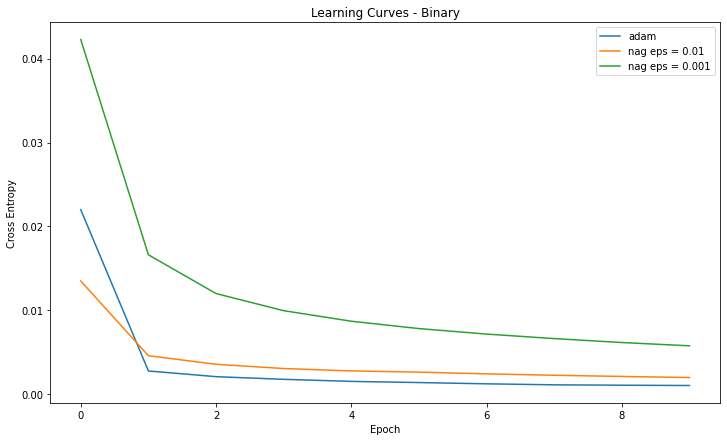

In [18]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'],label='adam')
plt.plot(history_nag_1.history['loss'],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect first 5 epochs

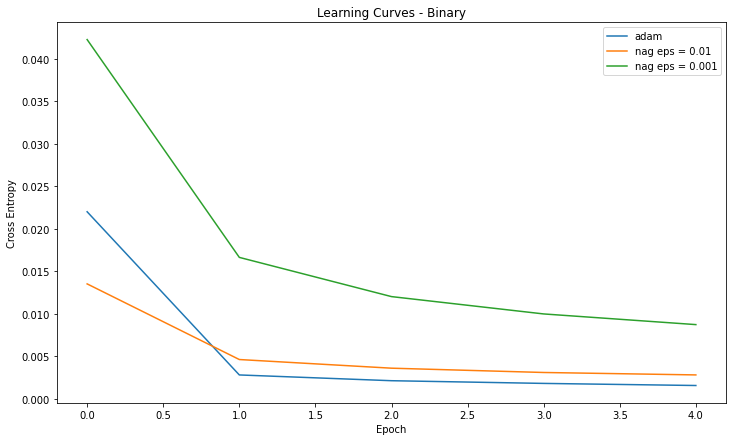

In [19]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'][:5],label='adam')
plt.plot(history_nag_1.history['loss'][:5],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'][:5],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect final 15 epochs

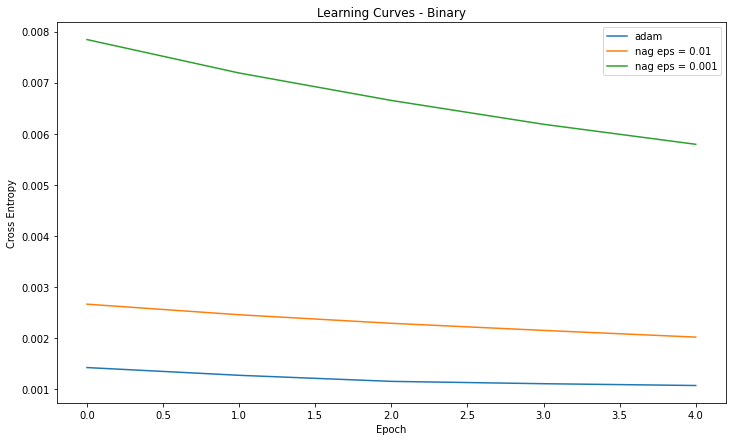

In [20]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'][5:],label='adam')
plt.plot(history_nag_1.history['loss'][5:],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'][5:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

#### Multiclass

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the multiclass case

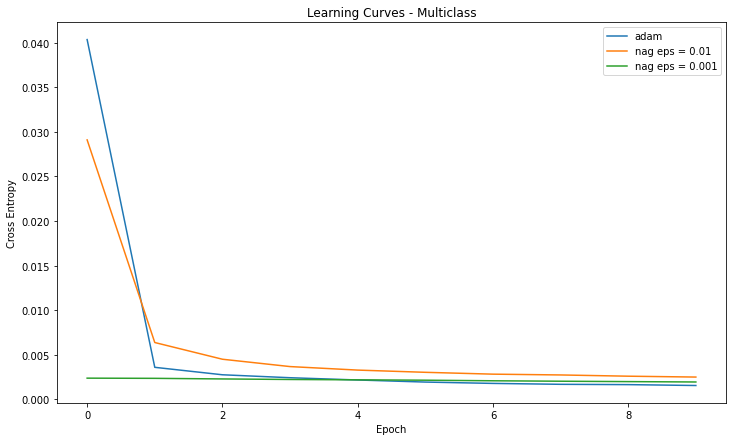

In [21]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'],label='adam')
plt.plot(history_nag_multi_1.history['loss'],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Plot first 5 epochs

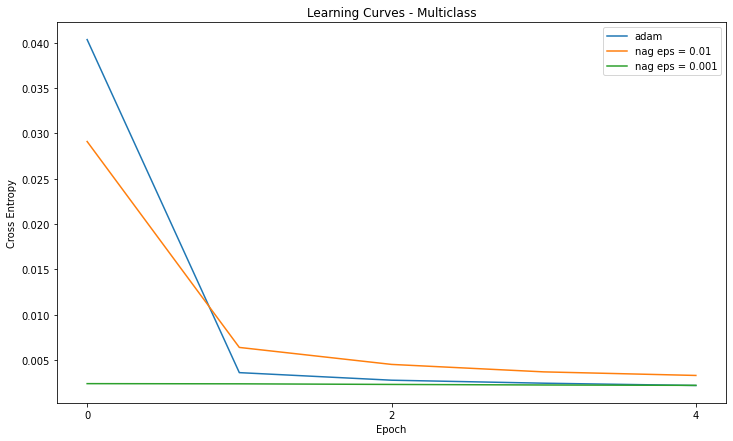

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'][:5],label='adam')
plt.plot(history_nag_multi_1.history['loss'][:5],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'][:5],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Plot last 15 epochs

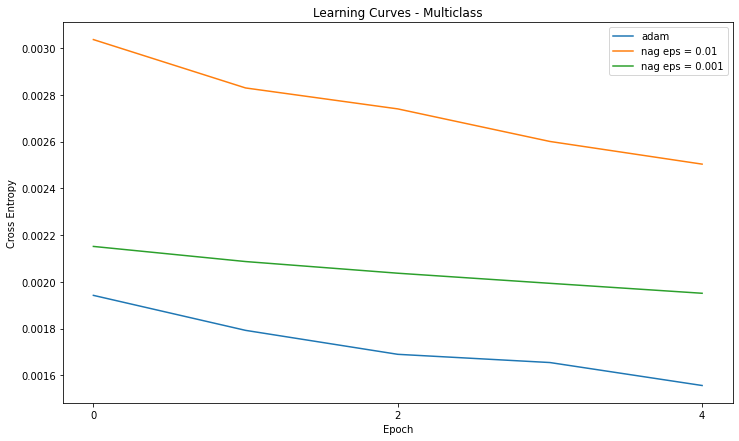

In [23]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'][5:],label='adam')
plt.plot(history_nag_multi_1.history['loss'][5:],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'][5:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

## Test

Test data

In [30]:
X_test = test_data[test_data.columns[:-2]]

#grab connection_category (normal vs dos vs u2r etc.)
test_targ = test_data.connection_category.copy()
#convert to numeric 0 normal, 1 attack
Y_test = test_targ.apply(lambda x: 0 if x=='normal' else 1)

Multiclass training (normal = `[1,0,0,0,0]`, u2r = `[0,1,0,0,0]` etc.)

In [27]:
Y_test_multi = pd.factorize(test_targ)[0]
Y_test_multi = tf.keras.utils.to_categorical(Y_test_multi,5)

In [64]:
adam_pred = nn_model1.predict(X_test,batch_size=1000)

In [65]:
adam_pred

array([[6.4400569e-06],
       [2.5367484e-05],
       [1.7445783e-06],
       ...,
       [1.0935867e-06],
       [1.3062875e-07],
       [9.2790579e-08]], dtype=float32)

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [58]:
def plotROC(y_true,y_pred,title='Title'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    plt.subplots(1, figsize=(12,7))

    plt.title(title)
    plt.plot(fpr, tpr)
    
    #plot y=x line for comparison
    plt.plot([0, 1], ls="--")
    #create right-angle shape indiciative of a perfect model
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    prob = roc_auc_score(y_true, y_pred)
    print('      ROC AUC Score: {:.4f}'.format(prob))

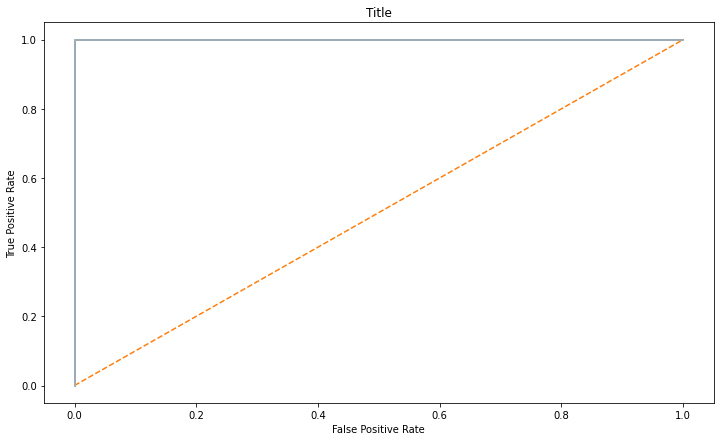

      ROC AUC Score: 1.0000


In [66]:
plotROC(Y_test,adam_pred)

In [67]:
adam_pred

array([[6.4400569e-06],
       [2.5367484e-05],
       [1.7445783e-06],
       ...,
       [1.0935867e-06],
       [1.3062875e-07],
       [9.2790579e-08]], dtype=float32)

In [74]:
binary_adam_pred = adam_pred
binary_adam_pred[binary_adam_pred<0.5]=0
binary_adam_pred[binary_adam_pred>0.5]=1
binary_adam_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [42]:
from sklearn.metrics import confusion_matrix

In [75]:
confusion_matrix(Y_test,binary_adam_pred)

array([[ 9733,     7],
       [   12, 39651]], dtype=int64)

Test multiclass on adam optimizer

In [ ]:
categ_model

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

In [14]:
categ_model = Sequential()
categ_model.add(Input(shape=X_train.shape[1],))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(5,activation='softmax'))
categ_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history_adam_multi = categ_model.fit(X_train,Y_train_multi,epochs=20,batch_size=1000)

Epoch 1/20
445/445 [==============================] - 3s 7ms/step - loss: 0.3265 - accuracy: 0.9014
Epoch 2/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0332 - accuracy: 0.9903
Epoch 3/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0186 - accuracy: 0.9952
Epoch 4/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0118 - accuracy: 0.9971
Epoch 5/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 6/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0070 - accuracy: 0.9988
Epoch 7/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9989
Epoch 8/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 9/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0041 - accuracy: 0.9992
Epoch 10/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0037 - accuracy: 0.9993

Test on NAG mwith varying learning rates

In [15]:
count = 1

for eps in [0.01,0.001]:
    
    #create optimizer with learning rate above
    opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                  momentum = 0.9, 
                                  nesterov = True)

    #same parameters as before, only changing optimizer
    nn_model2 = createDNN(X = X_train, 
                          hidden_nodes = [10,10,1],
                          activations = ['relu','relu','sigmoid'],
                          loss = 'binary_crossentropy',
                          optimizer=opt,
                          metric='accuracy')
    
    #same as before for categ
    categ_model = Sequential()
    categ_model.add(Input(shape=X_train.shape[1],))
    categ_model.add(Dense(10,activation='relu'))
    categ_model.add(Dense(10,activation='relu'))
    categ_model.add(Dense(5,activation='softmax'))
    categ_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    #better preview
    print('-'*5 + 'binary learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history = nn_model2.fit(X_train,Y_train,epochs=20,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_{}'.format(count)] = history
    
    #better preview
    print('-'*5 + 'multi learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history_multi = categ_model.fit(X_train,Y_train_multi,epochs=20,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_multi_{}'.format(count)] = history_multi
    
    
    #increase count for next iteration
    count += 1

-----binary learning rate 0.01-----
Epoch 1/20
4447/4447 [==============================] - 30s 7ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 2/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 3/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0039 - accuracy: 0.9989
Epoch 4/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 5/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 6/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 7/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 8/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 9/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 10/20
4447/4447 [==============

## Trial

NAG should work better than adam when batch size is large compared to training size. For example, here, we take 4446 data points and batch_size of 1000 and 30 epochs, for a total time taken of 0.3 seconds total runtime compared to the 6 minutes above.

In [114]:
for c in np.unique(y_train_multi,axis=0):
    c_count = sum(np.all(y_train_multi==c, axis=1))
    print(c, c_count)

[0. 0. 0. 0. 1.] 3695
[0. 0. 0. 1. 0.] 1006
[0. 0. 1. 0. 0.] 352330
[0. 1. 0. 0. 0.] 49
[1. 0. 0. 0. 0.] 87538


In [115]:
from sklearn.model_selection import train_test_split

In [118]:
X_train_small, X_test_small, y_train_small, y_test_small =  train_test_split(X_train, y_train_multi,
                                                                             test_size=0.9,random_state=42,
                                                                             shuffle=True,stratify=y_train_multi)

In [120]:
len(X_train_small), len(X_test_small), len(y_train_small), len(y_test_small)

(44461, 400157, 44461, 400157)

In [122]:
for c in np.unique(y_train_multi,axis=0):
    c_count = sum(np.all(y_train_small==c, axis=1))
    print(c, c_count)

[0. 0. 0. 0. 1.] 369
[0. 0. 0. 1. 0.] 101
[0. 0. 1. 0. 0.] 35232
[0. 1. 0. 0. 0.] 5
[1. 0. 0. 0. 0.] 8754


In [147]:
sm_adam = Sequential()
sm_adam.add(Input(shape=(X_train_small.shape[1],)))
sm_adam.add(Dense(10,activation='relu'))
sm_adam.add(Dense(5,activation='softmax'))
sm_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

sm_adam_hist = sm_adam.fit(X_train_small,y_train_small,epochs=30,batch_size=1000)

Epoch 1/30
45/45 [==============================] - 1s 8ms/step - loss: 1.6416 - accuracy: 0.2508
Epoch 2/30
45/45 [==============================] - 0s 6ms/step - loss: 0.5141 - accuracy: 0.8064
Epoch 3/30
45/45 [==============================] - 0s 6ms/step - loss: 0.3601 - accuracy: 0.8170
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2733 - accuracy: 0.9043
Epoch 5/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1731 - accuracy: 0.9520
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1172 - accuracy: 0.9626
Epoch 7/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0933 - accuracy: 0.9756
Epoch 8/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0803 - accuracy: 0.9789
Epoch 9/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0717 - accuracy: 0.9802
Epoch 10/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9813
Epoch 11/30
45/45 [

In [131]:
count = 1

for eps in [0.01,0.001]:
    sm_nag = Sequential()
    sm_nag.add(Input(shape=(X_train_small.shape[1],)))
    sm_nag.add(Dense(10,activation='relu'))
    sm_nag.add(Dense(5,activation='softmax'))
    sm_nag.compile(loss='categorical_crossentropy',optimizer=opt,metrics='accuracy')
    
    locals()['sm_nag_{}'.format(count)] = sm_nag
    
    opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                  momentum = 0.9, 
                                  nesterov = True)
    
    sm_nag_hist = sm_nag.fit(X_train_small,y_train_small,epochs=30,batch_size=1000)
    
    locals()['sm_nag_hist_{}'.format(count)] = sm_nag_hist
    del sm_nag_hist
    del sm_nag
    
    count+=1

Epoch 1/30
45/45 [==============================] - 1s 7ms/step - loss: 1.1387 - accuracy: 0.6508
Epoch 2/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2975 - accuracy: 0.8953
Epoch 3/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1859 - accuracy: 0.9504
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1546 - accuracy: 0.9544
Epoch 5/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.9554
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.9571
Epoch 7/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1266 - accuracy: 0.9584
Epoch 8/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1218 - accuracy: 0.9632
Epoch 9/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1177 - accuracy: 0.9656
Epoch 10/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1141 - accuracy: 0.9673
Epoch 11/30
45/45 [

#### Plot (Stratified)

In [135]:
for op in ['adam','nag_1','nag_2']:
    pred = locals()['sm_{}'.format(op)].predict(X_test_small)
    
    locals()['{}_small_pred'.format(op)] = pred
    
del pred

In [137]:
confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(adam_small_pred,axis=1))

array([[ 78584,      0,     41,     99,     60],
       [    28,      0,     11,      5,      0],
       [    64,      0, 317027,      0,      7],
       [   594,      0,    103,    208,      0],
       [    85,      0,    115,      0,   3126]], dtype=int64)

In [138]:
confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(nag_1_small_pred,axis=1))

array([[ 78208,      0,    576,      0,      0],
       [    44,      0,      0,      0,      0],
       [  2008,      0, 315090,      0,      0],
       [   871,      0,     34,      0,      0],
       [  1579,      0,   1747,      0,      0]], dtype=int64)

In [139]:
confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(nag_2_small_pred,axis=1))

array([[ 78408,      0,    342,      0,     34],
       [    26,      0,     18,      0,      0],
       [   139,      0, 316955,      0,      4],
       [   614,      0,    291,      0,      0],
       [   825,      0,   1889,      0,    612]], dtype=int64)

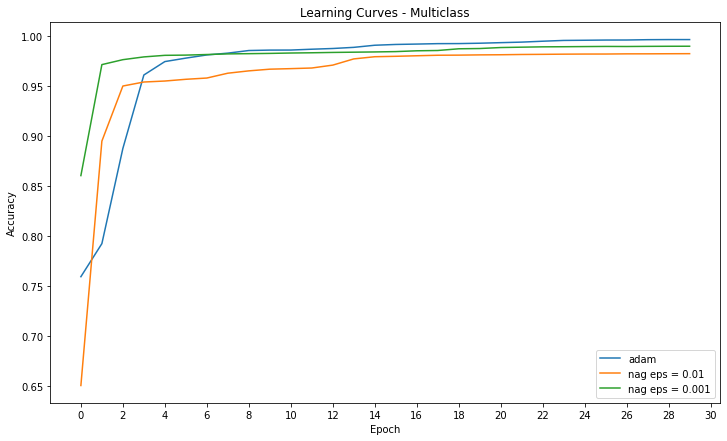

In [143]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Accuracy')

plt.plot(sm_adam_hist.history['accuracy'],label='adam')
plt.plot(sm_nag_hist_1.history['accuracy'],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['accuracy'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

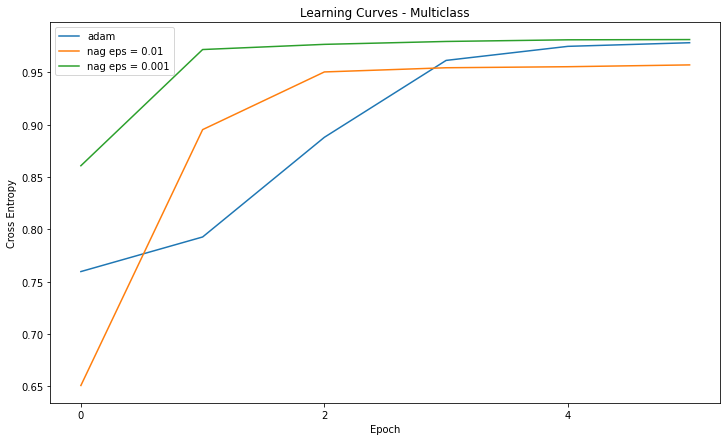

In [145]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['accuracy'][:6],label='adam')
plt.plot(sm_nag_hist_1.history['accuracy'][:6],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['accuracy'][:6],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

#### Plot (Unstratified)

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the multiclass classifier case

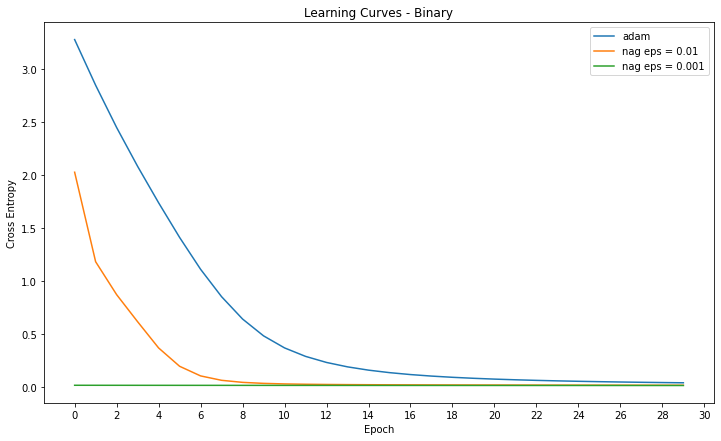

In [51]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'],label='adam')
plt.plot(sm_nag_hist_1.history['loss'],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect first 20 epochs

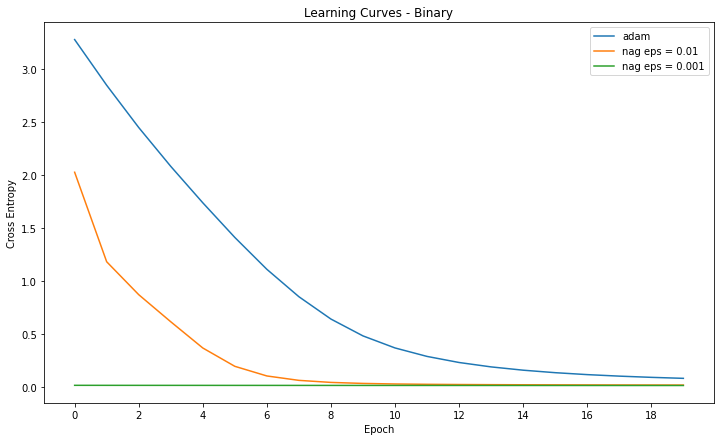

In [52]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,30,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'][:20],label='adam')
plt.plot(sm_nag_hist_1.history['loss'][:20],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'][:20],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

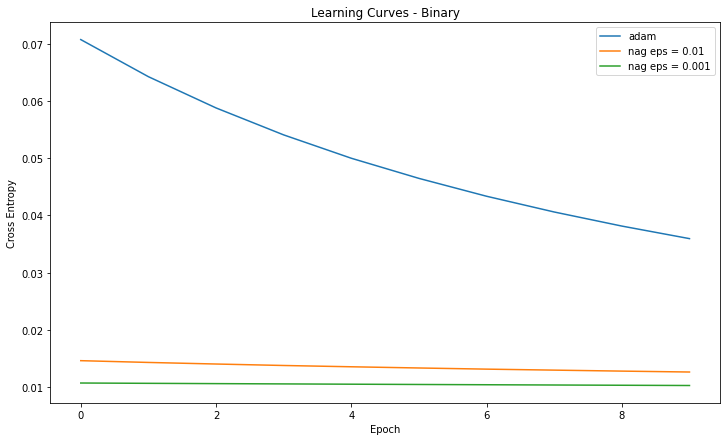

In [53]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'][20:],label='adam')
plt.plot(sm_nag_hist_1.history['loss'][20:],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'][20:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Prediction

In [56]:
ad_pred = sm_adam.predict(X_test)
nag_pred = sm_nag.predict(X_test)

In [70]:
len(ad_pred)

49403

In [72]:
tf.argmax(input=ad_pred,axis=0)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([  737, 34393, 48681, 34484, 34393], dtype=int64)>

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [73]:
ad_pred_cm = ad_pred

confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(ad_pred,axis=1))

array([[ 9740,     0,     0,     0,     0],
       [39128,     0,     0,     0,     0],
       [  120,     0,     0,     0,     0],
       [  412,     0,     0,     0,     0],
       [    3,     0,     0,     0,     0]], dtype=int64)

In [74]:
confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(nag_pred,axis=1))

array([[ 9740,     0,     0,     0,     0],
       [39128,     0,     0,     0,     0],
       [  120,     0,     0,     0,     0],
       [  404,     0,     4,     4,     0],
       [    3,     0,     0,     0,     0]], dtype=int64)